# 1. EFFECTIVENESS OF THE ONLINE LEARNING RULE

## Setup the environment

#### Adding the source code path

In [2]:
import sys  
sys.path.insert(1, './../../ESN-IP/IP/.')

In [3]:
import random

random.seed(10)

#### Import experiment data 

In [4]:
from DATA import MG17

data = MG17(True, [80,10,10])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()

## NOT PRETRAINED RESERVOIR

In [5]:
N_UNITS = 250

In [6]:
from IPReservoir import IPReservoir
from ESN import Reservoir
from IntrinsicPlasticity import IPMask

simple_reservoir = Reservoir(N = N_UNITS, sparsity=0.9, ro_rescale=0.25, bias = False)

W_x = simple_reservoir.W_x
W_u = simple_reservoir.W_u
b_x = simple_reservoir.b_x
b_u = simple_reservoir.b_u

## PRETRANING WITH OLD STYLE INTRINSIC PLASTICITY

In [7]:
ip_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.normalMask(N_UNITS), bias = True)

ip_reservoir.W_x = W_x
ip_reservoir.W_u = W_u
ip_reservoir.b_x = b_x
ip_reservoir.b_u = b_u

In [10]:
ip_reservoir.pre_train(X_TR, eta=0.00000025, epochs=5,  learning_rule="online", verbose=True) #16

No transient applied. Reservoir was already warmed up
- Epoch: 1) | KL Divergence value: 1473.04345703125.
- Epoch: 2) | KL Divergence value: 1473.328125.
- Epoch: 3) | KL Divergence value: 1473.613525390625.
- Epoch: 4) | KL Divergence value: 1473.89892578125.
- Epoch: 5) | KL Divergence value: 1474.1849365234375.


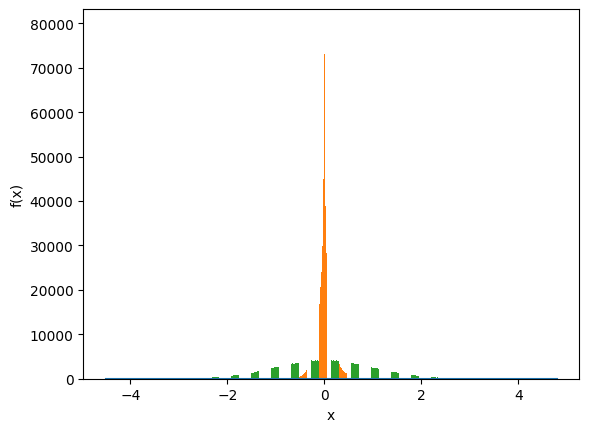

In [13]:
ip_reservoir.predict(X_TR, save_gradients=False, save_states=True)
ip_reservoir.plot_global_neural_activity()

In [14]:
ip_reservoir.predict(X_VAL, save_gradients=False, save_states=True)
ip_reservoir.sample_targets(X_VAL.shape[0], overwrite=True)

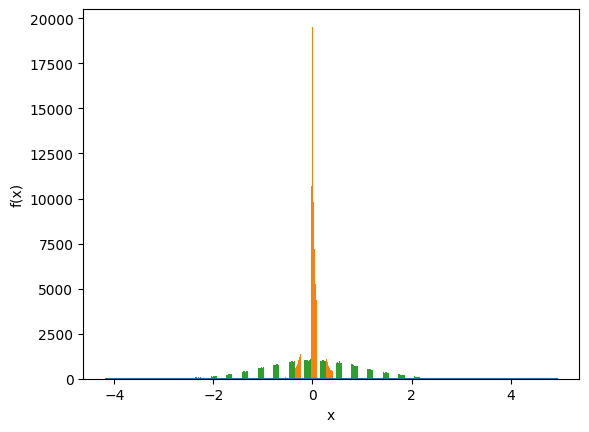

In [15]:
ip_reservoir.plot_global_neural_activity()

In [12]:
ip_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (0.001884734258055687)  ACTUAL_STD == (0.016652556136250496)][ TARGET_MEAN == (0.009677433408796787) TARGET_STD == (1.007393717765808)]
Unit - (2): [ ACTUAL_MEAN == (-0.012944022193551064)  ACTUAL_STD == (0.05622241646051407)][ TARGET_MEAN == (0.025845857337117195) TARGET_STD == (1.0099756717681885)]
Overall network: [ACTUAL_MEAN == (0.0034669486340135336)  ACTUAL_STD == (0.15584157407283783)]


## BIMODAL MIXTURE OF GAUSSIAN

In [18]:
# It seems that switching the "old" bias terms down (input bias and recurrent weights bias), 
# helps the algorithm converging earlier, letting the IP bias dominate the linear translation. 

bimodal_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.mixedBimodalMask(N_UNITS), bias = False)

bimodal_reservoir.W_x = W_x
bimodal_reservoir.W_u = W_u
# bimodal_reservoir.b_x = b_x
# bimodal_reservoir.b_u = b_u

In [28]:
bimodal_reservoir.pre_train(X_TR, eta=0.0000015, epochs=5,  learning_rule="online", verbose=True)

No transient applied. Reservoir was already warmed up
- Epoch: 1) | KL Divergence value: 1768.162841796875.
- Epoch: 2) | KL Divergence value: 1749.417724609375.
- Epoch: 3) | KL Divergence value: 1734.99951171875.
- Epoch: 4) | KL Divergence value: 1724.783447265625.
- Epoch: 5) | KL Divergence value: 1718.7462158203125.


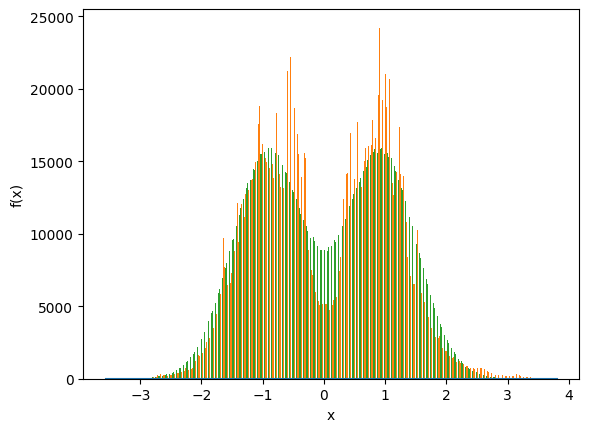

In [29]:
bimodal_reservoir.predict(X_TR, save_gradients=False, save_states=True)
bimodal_reservoir.plot_global_neural_activity()

In [30]:
bimodal_reservoir.predict(X_VAL, save_gradients=False, save_states=True)
bimodal_reservoir.sample_targets(X_VAL.shape[0], overwrite=True)

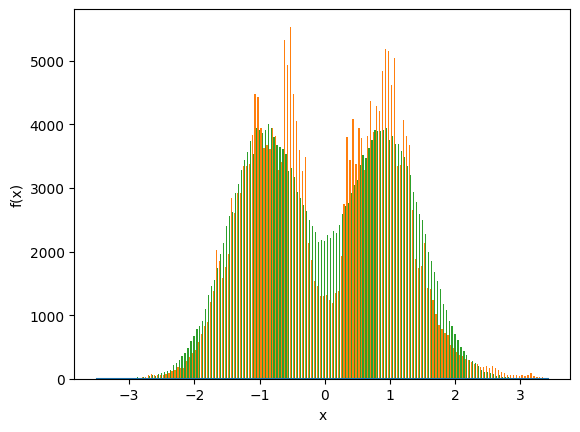

In [31]:
bimodal_reservoir.plot_global_neural_activity()

In [32]:
bimodal_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (-1.2547193765640259)  ACTUAL_STD == (0.08989295363426208)][ TARGET_MEAN == (-0.8983775973320007) TARGET_STD == (0.5819340944290161)]
Unit - (2): [ ACTUAL_MEAN == (1.569021224975586)  ACTUAL_STD == (0.1611756980419159)][ TARGET_MEAN == (0.8984326720237732) TARGET_STD == (0.59456467628479)]
Overall network: [ACTUAL_MEAN == (0.023647921159863472)  ACTUAL_STD == (1.056296467781067)]


## EVAUALTUION IN ESN

In [33]:
from ESN import EchoStateNetwork

simple_esn = EchoStateNetwork(simple_reservoir)
ip_esn = EchoStateNetwork(ip_reservoir)
bimodal_esn = EchoStateNetwork(bimodal_reservoir)

from Metrics import NRMSE, MSE

### HANDMADE UGLY LAMBDA SEARCH

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.00012605096029788006


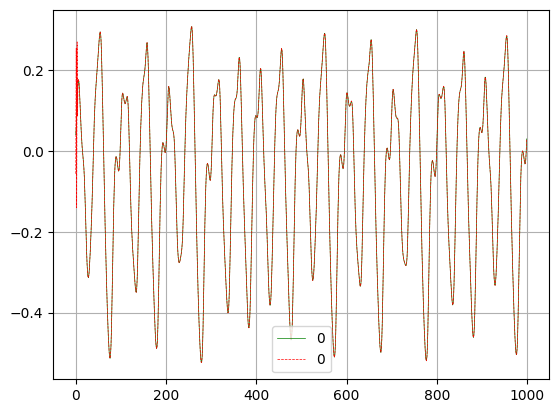

In [34]:
simple_esn.train(X_TR, Y_TR, 0)

#simple_esn.readout.predict(simple_esn.reservoir.predict(X_TR))

print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { simple_esn.evaluate(X_VAL, Y_VAL, metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 6.916089917463542e-06


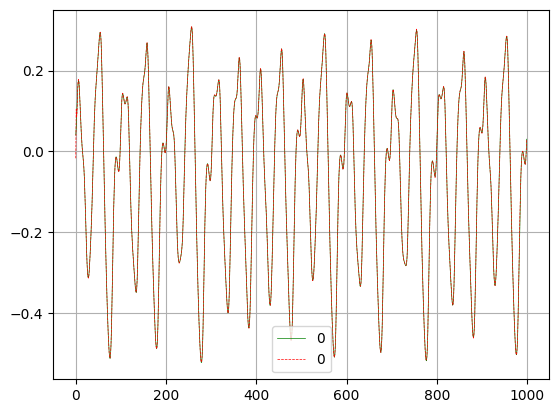

In [35]:

ip_esn.train(X_TR, Y_TR, 0)

print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { ip_esn.evaluate(X_VAL, Y_VAL, metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 9.451183021210813e-06


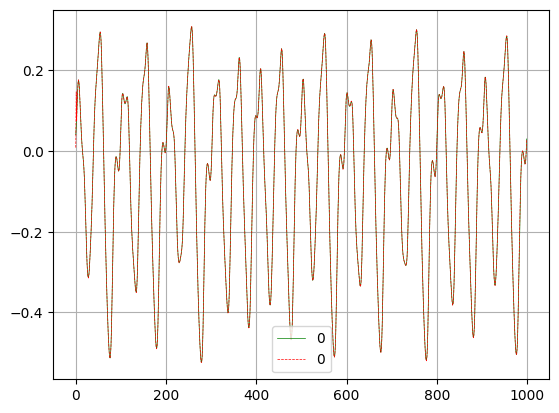

In [37]:
bimodal_esn.train(X_TR, Y_TR, 0)

print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { bimodal_esn.evaluate(X_VAL, Y_VAL, metric=MSE(), plot=True)}" )

### COMPARISON ON TEST DATA

NORMALIZED ROOT-MEAN SQUARE ERROR: 9.426640035486849e-05


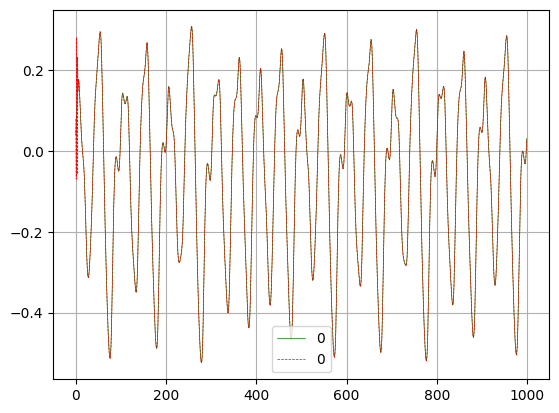

In [38]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { simple_esn.evaluate(X_TS, Y_TS, metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 5.911089413704017e-06


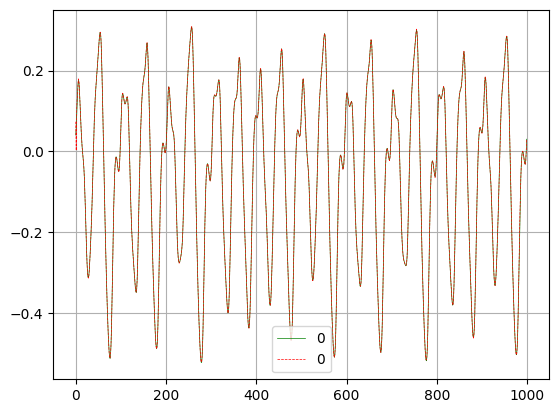

In [39]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { ip_esn.evaluate(X_TS, Y_TS, metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 1.6926922382441985e-06


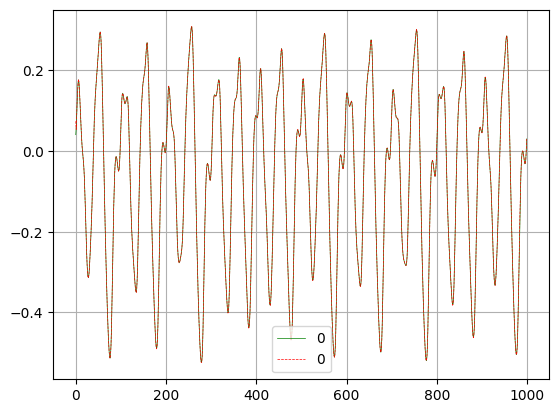

In [40]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { bimodal_esn.evaluate(X_TS, Y_TS, metric=MSE(), plot=True)}" )

## MEMORY CAPACITY

In [43]:
simple_esn.MemoryCapacity(1000,0)

tensor(33.8289)

In [44]:
ip_esn.MemoryCapacity(1000,0)

tensor(47.2718)

In [46]:
bimodal_esn.MemoryCapacity(1000,0)

tensor(2.9388)